In [ ]:
#! pip install matplotlib==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score #to evalute a classification model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
df_resume = pd.read_csv('resumes/resumes_train.csv')
df_resume.head()

,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


generate text embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

def generate_embeddings(text):
    model_name = "distilbert-base-uncased"
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModel.from_pretrained(model_name)

    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract embeddings (CLS token representation)
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().tolist()

    return embeddings

In [ ]:
# Generate embeddings for resumes
embeddings_list = []
for i in range(len(df_resume['resume'])):
    text_embeddings = generate_embeddings(df_resume['resume'][i])
    # print(len(text_embeddings))
    embeddings_list.append(text_embeddings)

Store embeddings in df

In [ ]:
# define df column names
column_names = ["embedding_" + str(i) for i in range(len(embeddings_list[0]))]

# store text embeddings in dataframe
df_train = pd.DataFrame(embeddings_list, columns=column_names)

# create target variable
df_train['is_data_scientist'] = df_resume['role']=="Data Scientist"
df_train.to_csv('resumes/embeddings_train.csv', index=False)
df_train.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767,is_data_scientist
0,-0.378027,0.011968,-0.161120,0.158366,-0.093132,-0.066202,0.330892,0.247856,-0.095920,-0.295393,...,-0.139298,-0.044172,-0.290272,0.157383,-0.157141,-0.267745,-0.210364,0.291331,0.237211,True
1,-0.300876,-0.131827,-0.213407,0.138219,0.077018,0.014622,0.153033,0.335961,-0.118446,-0.260240,...,-0.265806,-0.016759,-0.255768,0.031882,0.029229,-0.262468,-0.262859,0.271974,0.277241,True
2,-0.251994,-0.205854,-0.177759,0.026434,-0.027457,0.135994,0.253748,0.352466,-0.210874,-0.438073,...,-0.282939,-0.054534,-0.292312,0.143631,-0.123491,-0.156776,-0.191297,0.240348,0.218837,True
3,-0.432973,-0.101257,-0.211164,0.051434,-0.019515,-0.070413,0.199725,0.323998,-0.126897,-0.374809,...,-0.182272,-0.042760,-0.274183,0.015779,-0.172126,-0.244781,-0.136237,0.221917,0.268288,True
4,-0.248352,-0.187275,-0.283300,0.012459,-0.010312,0.071432,0.281609,0.309400,-0.226950,-0.354940,...,-0.202876,-0.113374,-0.228228,0.094591,-0.137262,-0.156742,-0.243463,0.302713,0.272354,True


Visualize embeddings with PCA

In [50]:
# split variables by predictors and target
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

# apply PCA to predictors (i.e. embeddings)
pca = PCA(n_components=2).fit(X)
print(pca.explained_variance_ratio_)

[0.12880747 0.10102555]


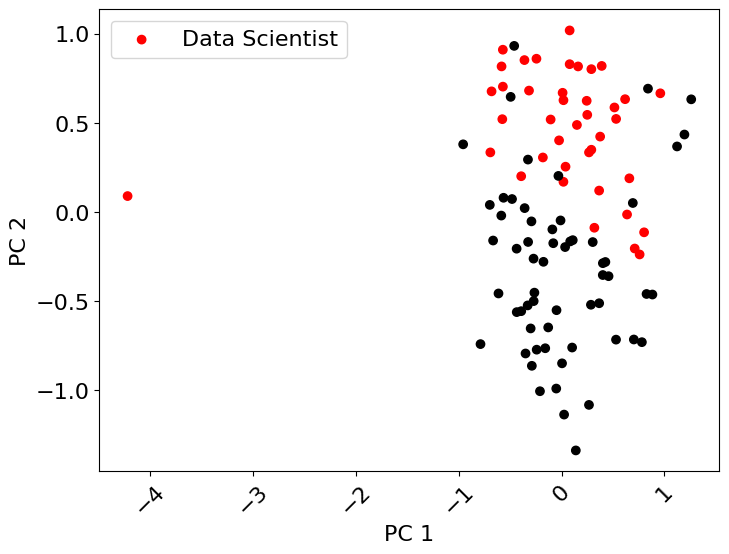

In [55]:
# plot data along PCA components
c_arr = np.array(["k"] * len(y))
c_arr[y] = "r"

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=c_arr)
plt.legend(["Data Scientist"])
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

Train Random Forest Model

In [56]:
# train rf model
clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X, y)
clf.score(X,y) # model accuracy for training data

0.99

In [57]:
# AUC value for training data
auc_val = roc_auc_score(y, clf.predict_proba(X)[:,1])
auc_val

1.0

In [58]:
# print feature importance ranking
feature_importances = pd.Series(clf.feature_importances_, index=column_names)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted[:25])

embedding_604    0.061801
embedding_753    0.026148
embedding_637    0.023453
embedding_427    0.022860
embedding_159    0.022620
embedding_532    0.022000
embedding_79     0.021872
embedding_200    0.020662
embedding_102    0.017537
embedding_131    0.016397
embedding_567    0.015977
embedding_635    0.015669
embedding_322    0.014167
embedding_754    0.012567
embedding_530    0.012014
embedding_93     0.011821
embedding_168    0.011241
embedding_531    0.011099
embedding_506    0.010850
embedding_409    0.010554
embedding_128    0.010343
embedding_315    0.009919
embedding_98     0.009678
embedding_123    0.009529
embedding_8      0.009247
dtype: float64


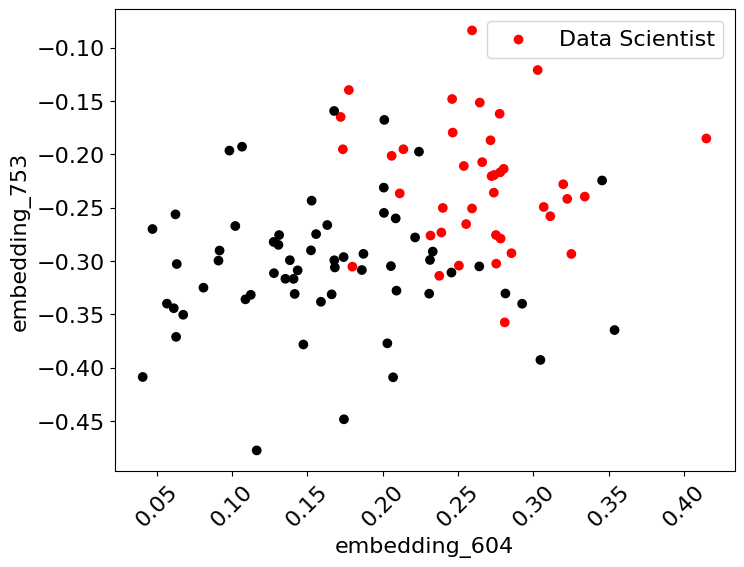

In [59]:
# plot data along top 2 most important features
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(X[feature_importances_sorted.index[0]], X[feature_importances_sorted.index[1]], c=c_arr)
plt.legend(["Data Scientist"])
plt.xticks(rotation = 45)
plt.xlabel(feature_importances_sorted.index[0])
plt.ylabel(feature_importances_sorted.index[1])
plt.show()

evaluate model on testing data

In [63]:
# import testing data
df_resume = pd.read_csv('resumes/resumes_test.csv')

# generate embeddings
# text_embedding_list = generate_embeddings(df_resume['resume'])
testing_embeddings_list = []
for i in range(len(df_resume['resume'])):
    text_embeddings = generate_embeddings(df_resume['resume'][i])
    testing_embeddings_list.append(text_embeddings)
    # break
# print(testing_embeddings_list)

# testing_embeddings_list = [testing_embeddings_list[i].embedding for i in range(len(testing_embeddings_list))]

# store text embeddings in dataframe
df_test = pd.DataFrame(testing_embeddings_list, columns=column_names)

# create target variable
df_test['is_data_scientist'] = df_resume['role']=="Data Scientist"
df_test.to_csv('resumes/embeddings_test.csv', index=False)
df_test.head()

# define predictors and target
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [64]:
# accuracy
clf.score(X_test,y_test)

0.8

In [65]:
# auc
auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
auc_val

0.9183333333333333

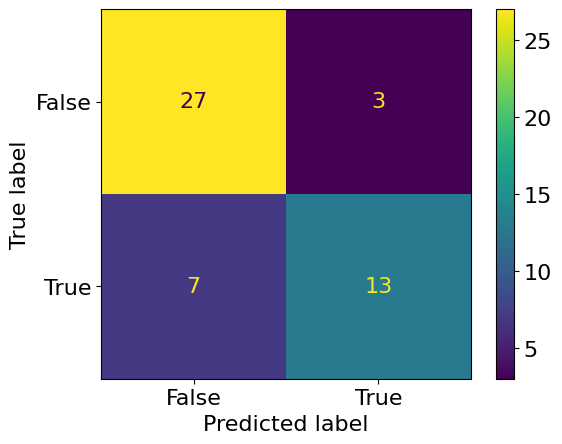

In [66]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [67]:
# look at errors
df_errors = df_resume[y_test != clf.predict(X_test)]
print(df_errors.iloc[0,0])

I. **Name:** John Smith

II. **Summary:**
A highly skilled Data Scientist with a strong background in statistical analysis and machine learning. Experienced in interpreting and analyzing complex data sets to drive business decisions and strategies. Proven ability to develop predictive models and algorithms to solve challenging problems.

III. **Professional Experience:**
1. *Data Scientist* at Tech Innovations Inc., San Francisco, CA
   - Developed machine learning models to optimize marketing strategies, resulting in a 15% increase in conversions.
   - Conducted in-depth data analysis to identify trends and insights for product development.

2. *Senior Data Analyst* at Data Solutions Co., New York, NY
   - Led a team to automate data collection processes, saving over 100 man-hours per month.
   - Collaborated with cross-functional teams to provide data-driven solutions for various business challenges.

IV. **Education:**
- *Master of Science in Data Science*, University of California,